<a href="https://colab.research.google.com/github/Beam-coder/ds2-2022/blob/main/project/P5_Mingqian_LIANG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P5 - Ocean Warming (global analysis)
## Authors: Mingqian LIANG, Xiran Zhang

# Access to data in the cloud (GCS)

In [ ]:
!pip install --upgrade dask distributed xarray zarr gcsfs cftime nc-time-axis intake intake-xarray

     |████████████████████████████████| 1.0 MB 3.7 MB/s 
     |████████████████████████████████| 822 kB 47.5 MB/s 
     |████████████████████████████████| 845 kB 34.4 MB/s 
     |████████████████████████████████| 146 kB 46.5 MB/s 
     |████████████████████████████████| 1.5 MB 34.0 MB/s 
     |████████████████████████████████| 1.9 MB 52.2 MB/s 
     |████████████████████████████████| 596 kB 59.7 MB/s 
     |████████████████████████████████| 133 kB 47.6 MB/s 
     |████████████████████████████████| 6.2 MB 9.1 MB/s 
     |████████████████████████████████| 1.1 MB 57.2 MB/s 
     |████████████████████████████████| 271 kB 59.9 MB/s 
     |████████████████████████████████| 160 kB 60.8 MB/s 
     |████████████████████████████████| 144 kB 60.5 MB/s 
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=8b46d292db93f61309a936c3d87036fdd47e03176ba1942b5f23b05cbdd5c459
  Stored in directory: /root/.cache/pip/wheels/12/1c/38/0def51e15add93bff3f4bf9c248b94db0839b

In [ ]:
import xarray as xr
from intake import open_catalog
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.linear_model import LinearRegression

### Access and listing of the catalog

In [ ]:
catalog_url = 'https://raw.githubusercontent.com/obidam/ds2-2022/main/ds2_data_catalog.yml'
cat = open_catalog(catalog_url)
list(cat)

['argo_global_sdl',
 'argo_global_sdl_homogeneous',
 'argo_global_vertical_mean',
 'en4',
 'sea_surface_height']

### Connect to data

In [ ]:
ds = cat["en4"].to_dask()
print("Size of the dataset:", ds.nbytes/1e9,"Gb")
ds

Size of the dataset: 52.2317975 Gb


<xarray.Dataset>
Dimensions:                          (depth: 42, time: 832, bnds: 2, lat: 173, lon: 360)
Coordinates:
  * depth                            (depth) float32 5.022 15.08 ... 5.35e+03
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 359.0 360.0
  * time                             (time) datetime64[ns] 1950-01-16T12:00:0...
Dimensions without coordinates: bnds
Data variables:
    depth_bnds                       (time, depth, bnds) float32 dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature                      (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_observation_weights  (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    time_bnds                        (time, bnds) datetime64[ns] dask.array<chunksize=(832, 2), meta=np.ndarray>
Attributes: (12/21)
    Conventions:            CF-1.0
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    GDS_version_id:         v1.7
    contact:                Simon Good - simon.good@metoffice.gov.uk
    creation_date:          2017-04-21 21:12:08.123 -00:00
    easternmost_longitude:  362.5
    ...                     ...
    start_date:             2001-01-01 UTC
    start_time:             00:00:00 UTC
    stop_date:              2001-01-01 UTC
    stop_time:              00:00:00 UTC
    title:                  Temperature and salinity analysis
    westernmost_longitude:  0.5

To save the calculation time, we just analyse the depth smaller than 750 metres.

In [22]:
def choose_depth(depth_bnds, temp, depth_limit):
    depth_bnds_limit = depth_bnds.where(depth_bnds < depth_limit, other = depth_limit)
    delta_depth = abs(depth_bnds_limit[:,:, 1] - depth_bnds_limit[:,:, 0])

    delta_depth_limited = delta_depth.where(delta_depth != 0, drop = True)
    temp_limited = temp.where(delta_depth != 0, drop = True)

    return delta_depth_limited, temp_limited

In [27]:
temp = ds.temperature       
depth_bnds = ds.depth_bnds
delta_level_limited, temp_limited = choose_depth(depth_bnds, temp, 750)  # Calcalate the OHC over 750m
ohc = ocean_heat_content(delta_level_limited, temp_limited)

/usr/local/lib/python3.7/dist-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


We firstly have to calcalate the Ocean Heat Content . 
The areal density of ocean heat content between two depths is defined as a definite integral:
$$H = C \int_{h_1}^{h_2} \rho(z)T(z) dz$$
where $C$ is the specific heat capacity of sea water, $h_2$ is the lower depth, $h_1$ is the upper depth, $\rho$ is the seawater density profile, and $T(z)$ is the temperature profile. In SI units, $H$ has units of Joules per square metre ($J·m^{−2}$) . (via Wikipedia)

This function is used to filter out the data we want at a certain depth . The output is the depth of each layer after filtration, and the corresponding temperature of each layer . 

The function to calculate the areal density of ocean heat content is :

In [23]:
def ocean_heat_content(delta_level_limited, temp_limited):
    rho = 1026 #kg/m^3, the mean density value
    c = 3990 #J/(kg K)
    ohc = (delta_level_limited*temp_limited*delta_s).sum("depth")
    ohc *= rho
    ohc *= c
    return ohc

In [30]:
# heat = calc_ocean_heat(delta_level_limited, temperature_limited)
heat_time_begin = ohc.isel(time=3)
heat_time_end = ohc.isel(time=-1)

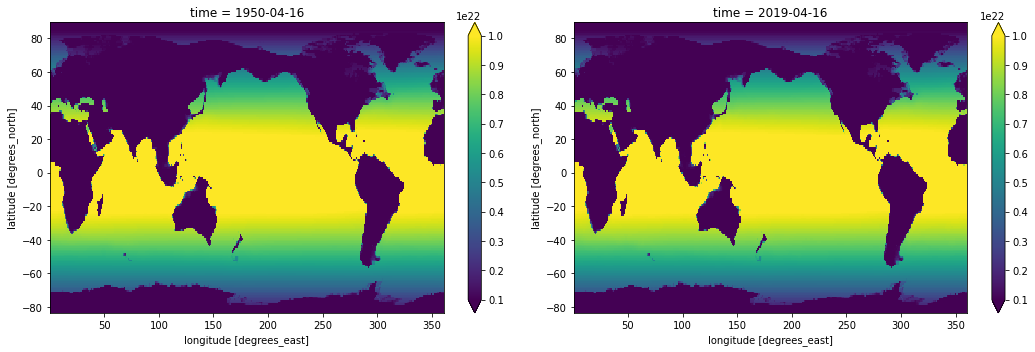

In [38]:
cmin = 1e21
cmax = 1e22
cnorm = colors.Normalize(cmin, cmax)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
heat_time_begin.plot(ax=axes[0], norm=cnorm)
heat_time_end.plot(ax=axes[1], norm=cnorm)
plt.tight_layout()

The two maps above are not the same, though very similar. This is because there is not a big difference at a local area.

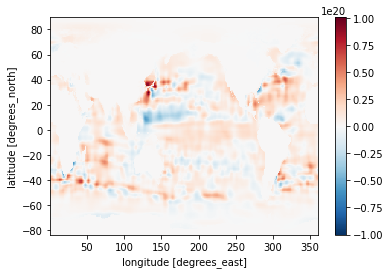

In [39]:
ohc_1950 = ohc.sel(time=slice('1950-01-01','1950-02-01')).squeeze('time')
ohc_2019 = ohc.sel(time=slice('2019-01-01','2019-02-01')).squeeze('time')
(ohc_2019-ohc_1950).plot()

Comments : The greatest increase of OHC can be seen in the Bohai sea and Yellow sea of China . This reflects the China's industrialisation as well as the exceeded CO2 emissions has caused the rise in temperature of its nearby seas . It is sad to see my country here.

Text(0, 0.5, 'OHC/(J⋅$m^{-2}$)')

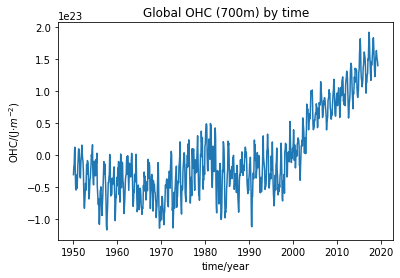

In [45]:
ohc_total = ohc.sum('lat').sum('lon')
plt.plot(ohc_total.time,ohc_total-ohc_total.mean())
plt.title('Global OHC (700m) by time')
plt.xlabel('time/year')
plt.ylabel('OHC/(J⋅$m^{-2}$)')

To better understand the trends and compare with the data on the site: https://www.ncei.noaa.gov/access/global-ocean-heat-content/ , I have plotted the quarterly (3-month) rolling average, the annual rolling average, the 5-year rolling average of the standardized data

In [40]:
def standardize(x):
     return (x-x.mean())/x.std()

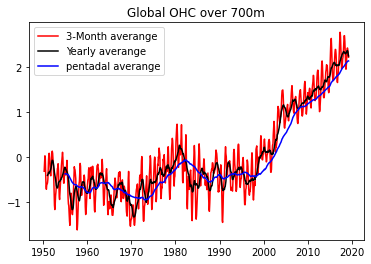

In [41]:
ohc_y_av = standardize(ohc_total).rolling(time=12).mean()
ohc_3m_av = standardize(ohc_total).rolling(time=3).mean()
ohc_p_av = standardize(ohc_total).rolling(time=60).mean()
plt.figure()
plt.plot(ohc_3m_av.time,ohc_3m_av,label='3-Month averange',color='r')
plt.plot(ohc_y_av.time,ohc_y_av,label='Yearly averange',color='black')
plt.plot(ohc_p_av.time,ohc_p_av,label='pentadal averange',color='b')
plt.legend()
plt.title('Global OHC over 700m')
plt.show()

Comments : Although the global OHC has varied greatly over a short period of time, it is easy to see that it is on an overall upward trend. At about 2000, there is a dividing line: before 2000 the rate of rise was relatively flat and we can vaguely see a sinusoidal cyclical change; after 2000 the rate of rise increased significantly

# Regression Methods

We implement non-linear regression of the pentadal average data.

In [ ]:
from sklearn.svm import SVR

# t = OHC_700.time.values[30:-29]
t = np.arange(0,773,1)
y = (ohc_p_av.values[30:-29])/1e26
# specify epsilon: the half-width of the "corridor" of data around the fitted line
epsilon = 1e-6

# set up a generic instance of the model
model=SVR(C=1e1, epsilon=epsilon)
# C is the "regularisation" term: this stops
# the model from becoming too complicated (overfitting)
# smaller C gives stronger regularisation (i.e. a simpler model)

# fit the model
model.fit(t[:,None],y)

# and predict values of ŷ
y_hat=model.predict(t[:,None])

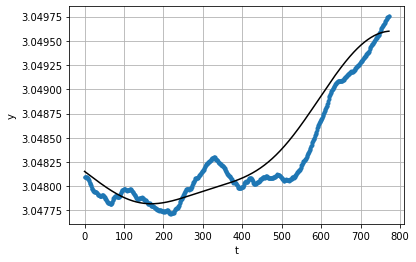

In [ ]:
# plot the results
plt.plot(t,y,'.')
plt.plot(t,y_hat,'k-')
plt.xlabel('t')
plt.ylabel('y')
plt.grid()

However, we cannot use this method to extrapolate the future situation as SVR is a kernel method.

### East Asia Sea

We focus on east Asia sea.

/usr/local/lib/python3.7/dist-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


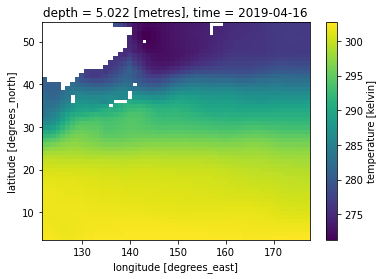

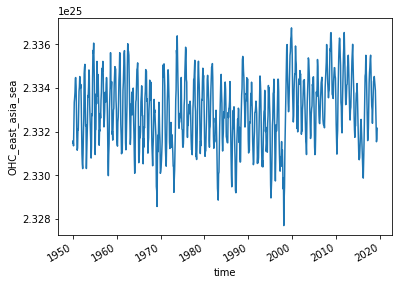

In [ ]:
# East Asia Sea

tata = (heat*ds['dx']*ds['dy'])
ds['OHC_east_asia_sea'] = tata.where((temp.lat>=4) & (temp.lat<=54) & (temp.lon>121) & (temp.lon<178), drop = True).sum(dim = 'lat').sum(dim = 'lon')
temp.where((temp.lat>=4) & (temp.lat<=54) & (temp.lon>121) & (temp.lon<178), drop = True).isel(depth=0).isel(time=-1).plot()
plt.title('OHC of the east Asia sea area')

plt.figure()

OHC_east_asia_sea = ds['OHC_east_asia_sea'].compute()
OHC_east_asia_sea.plot()

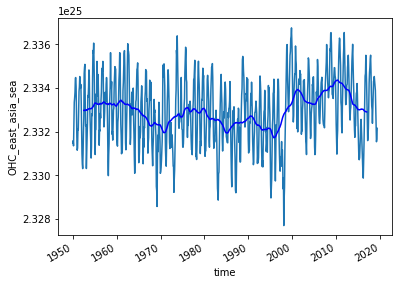

In [ ]:
ohc_p_av_eas = OHC_east_asia_sea.rolling(time=60, center=True).mean()
plt.figure()
OHC_east_asia_sea.plot()
plt.plot(ohc_p_av_eas.time,ohc_p_av_eas,label='pentadal average',color='b')

There is not an obvious OHC's trend of the east Asia sea, so there is no need to do the regression.